# All-NBA Team Binary Classification Model

Will use various classification algorithms(logisitic regression, KNN, SVM, etc) and evaluate performance on dataset.

In [193]:
import pandas as pd
import numpy as np 
import torch
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import sklearn
from sklearn import *
from sklearn.metrics import *
import pickle

## Load and analyze dataset

Preview features (player, games started, minutes played, etc.) and training examples (the players).

In [194]:
DATADIR = "DataSet.csv"
df = pd.read_csv(DATADIR) # read dataset
df.head() # preview first few features and rows

,Player,G,GPnS%,GPnSround%,GS,MP,FG,FGA,FG%,3P,...,STL,BLK,TOV,PF,PTS,PER,WS,BPM,VORP,All-NBA?
0,Precious Achiuwa,61,0.055556,0.0556,4,12.1,2.0,3.7,0.544,0.0,...,0.3,0.5,0.7,1.5,5.0,14.2,1.3,-4.5,-0.5,0
1,Jaylen Adams,7,0.000000,0.0000,0,2.6,0.1,1.1,0.125,0.0,...,0.0,0.0,0.0,0.1,0.3,-6.5,-0.1,-19.8,-0.1,0
2,Steven Adams,58,0.805556,0.8056,58,27.7,3.3,5.3,0.614,0.0,...,0.9,0.7,1.3,1.9,7.6,15.1,4.0,-0.8,0.5,0
3,Bam Adebayo,64,0.888889,0.8889,64,33.5,7.1,12.5,0.570,0.0,...,1.2,1.0,2.6,2.3,18.7,22.7,8.8,4.7,3.6,0
4,LaMarcus Aldridge,26,0.319444,0.3194,23,25.9,5.4,11.4,0.473,1.2,...,0.4,1.1,1.0,1.8,13.5,15.7,1.1,-0.6,0.2,0


Look at list of all features.

In [195]:
df.columns # list of columns

Index(['Player', 'G', 'GPnS%', 'GPnSround%', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'PER', 'WS', 'BPM', 'VORP', 'All-NBA?'],
      dtype='object')

Remove player column from dataset and store it in numpy array.

In [196]:
players = df.pop('Player') # remove Player column from dataSet and store in players
players = np.array(players) # cast players from list into numpy array

Examine players numpy array.

In [197]:
players

array(['Precious Achiuwa', 'Jaylen Adams', 'Steven Adams', ...,
       'Andre Drummond', 'Klay Thompson', 'Kyle Lowry'], dtype=object)

## Find correlation between features and target variable

Use a correlation matrix to determine the features with the strongest correlation to the target variable (All-NBA?). Look at the leftmost and rightmost column to analyze strongest features.

In [198]:
# dataSet.corr()    this prints the correlation matrix for all other features
df.corrwith(df["All-NBA?"])

G             0.275890
GPnS%         0.454324
GPnSround%    0.454319
GS            0.471530
MP            0.402598
FG            0.551768
FGA           0.524672
FG%           0.127382
3P            0.297344
3PA           0.297626
3P%           0.061744
2P            0.540380
2PA           0.532232
2P%           0.087835
eFG%          0.100872
TRB           0.418248
AST           0.475572
STL           0.435999
BLK           0.274642
TOV           0.535496
PF            0.219371
PTS           0.581269
PER           0.420605
WS            0.703642
BPM           0.382282
VORP          0.779935
All-NBA?      1.000000
dtype: float64

## Feature Selection

Choose features based on strongest correlation with target variable.

In [199]:
# include all rows and only the listed colums
df = df.loc[:, ["GS", "FG", "FGA", "2P", "2PA", "AST", 
                "TOV", "PTS", "WS", "VORP", "All-NBA?"]] 

## Feature Engineering

Develop new features based on existing features. For example, the AST/TOV ratio is a commonly used statistic in evaluating the playmaking ability of a player.

In [200]:
df['AST/TOV'] = df.apply(lambda x: x['AST'] / x['TOV'] if x['TOV'] != 0 else 1, axis = 1)

In [201]:
df['AST/TOV']

0       0.714286
1       1.000000
2       1.461538
3       2.076923
4       1.900000
          ...   
1110    1.242424
1111    1.153846
1112    0.421053
1113    1.235294
1114    2.206897
Name: AST/TOV, Length: 1115, dtype: float64

In [202]:
df.corrwith(df['All-NBA?'])

GS          0.471530
FG          0.551768
FGA         0.524672
2P          0.540380
2PA         0.532232
AST         0.475572
TOV         0.535496
PTS         0.581269
WS          0.703642
VORP        0.779935
All-NBA?    1.000000
AST/TOV     0.024009
dtype: float64

AST/TOV doesn't have a strong positive correlation with making an All-NBA team, so we'll discard it.

In [203]:
df = df.drop('AST/TOV', axis = 1)
df

,GS,FG,FGA,2P,2PA,AST,TOV,PTS,WS,VORP,All-NBA?
0,4,2.0,3.7,2.0,3.7,0.5,0.7,5.0,1.3,-0.5,0
1,0,0.1,1.1,0.1,0.9,0.3,0.0,0.3,-0.1,-0.1,0
2,58,3.3,5.3,3.3,5.3,1.9,1.3,7.6,4.0,0.5,0
3,64,7.1,12.5,7.1,12.4,5.4,2.6,18.7,8.8,3.6,0
4,23,5.4,11.4,4.2,8.3,1.9,1.0,13.5,1.1,0.2,0
...,...,...,...,...,...,...,...,...,...,...,...
1110,81,7.5,17.9,4.9,10.9,4.1,3.3,23.1,9.2,4.9,1
1111,74,7.2,14.1,7.2,13.9,1.5,1.3,18.0,10.1,2.5,1
1112,81,6.8,13.1,6.8,13.0,0.8,1.9,16.2,7.4,2.0,1
1113,80,8.1,17.3,4.7,9.2,2.1,1.7,22.1,8.0,2.5,1


## Feature Scaling

Scale features so that they have a uniform range. In this case we'll use Z-score normalization, which uses the following equation: $$ x_{n} = \frac{x_{n} - \mu_{n}}{\sigma_{n}} $$
where $ x_n $ is the row of the nth column, $ \mu_{n} $ is the mean of the nth column, and $ \sigma_{n} $ is the standard deviation of the nth column.

In [204]:
features_df = df.drop("All-NBA?", axis = 1)
for col in features_df:
    df[col] = (df[col] - np.mean(df[col])) / np.std(df[col])
len(features_df.columns)

10

In [205]:
np.save('min_values.npy', df.min().values)
np.save('max_values.npy', df.max().values)

In [206]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_sample = self.data[idx]     # Replace with your input feature data
        target_sample = self.labels[idx]  # Replace with your target label data

        return {'input': input_sample, 'target': target_sample}


Seperate target variable from features and convert to tensors.

In [207]:
from torch.utils.data import DataLoader, random_split, TensorDataset

X = df[['GS', 'FG', 'FGA', '2P', '2PA', 'AST', 'TOV', 'PTS', 'WS', 'VORP']].values  
Y = df[['All-NBA?']].values  

# Convert NumPy arrays to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

Perform train-test data split and create dataloaders.

In [208]:
dataset = TensorDataset(X, Y)

train_ratio = 0.7
test_ratio = 1.0 - train_ratio

num_samples = len(dataset)
train_size = int(train_ratio * num_samples)
test_size = num_samples - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

X_train, Y_train = train_dataset.dataset[train_dataset.indices]
X_test, Y_test = test_dataset.dataset[test_dataset.indices]

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Defining the Model

We'll use a sequential neural network with 2 hidden layers and a sigmoid activation function for the output layer for the binary classification. Binary Cross Entropy Loss is the used loss function, while adam is the optimizer algorithm.

In [209]:
import torch.nn as nn
class CustomModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(CustomModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [210]:
import torch.optim as optim
model = CustomModel(len(features_df.columns), 32, 16)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)


## Training Neural Network

Perform forward propagation and back propagation when training neural network.

In [211]:
num_epochs = 100


for epoch in range(num_epochs):
    model.train()  
    total_loss = 0.0

    for inputs, labels in train_dataloader:  
        
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {average_loss:.4f}')

torch.save(model.state_dict(), 'nbamodel.pt')


Epoch [1/100], Training Loss: 0.6528
Epoch [2/100], Training Loss: 0.5935
Epoch [3/100], Training Loss: 0.5255
Epoch [4/100], Training Loss: 0.4530
Epoch [5/100], Training Loss: 0.3622
Epoch [6/100], Training Loss: 0.3073
Epoch [7/100], Training Loss: 0.2437
Epoch [8/100], Training Loss: 0.2101
Epoch [9/100], Training Loss: 0.1820
Epoch [10/100], Training Loss: 0.1607
Epoch [11/100], Training Loss: 0.1411
Epoch [12/100], Training Loss: 0.1245
Epoch [13/100], Training Loss: 0.1069
Epoch [14/100], Training Loss: 0.1018
Epoch [15/100], Training Loss: 0.0911
Epoch [16/100], Training Loss: 0.0910
Epoch [17/100], Training Loss: 0.0764
Epoch [18/100], Training Loss: 0.0703
Epoch [19/100], Training Loss: 0.0710
Epoch [20/100], Training Loss: 0.0722
Epoch [21/100], Training Loss: 0.0590
Epoch [22/100], Training Loss: 0.0579
Epoch [23/100], Training Loss: 0.0596
Epoch [24/100], Training Loss: 0.0545
Epoch [25/100], Training Loss: 0.0541
Epoch [26/100], Training Loss: 0.0513
Epoch [27/100], Train

## Testing neural network on testing dataset

Evaluate performance on testing dataset.

In [212]:
model.eval()  
test_loss = 0.0
correct_predictions = 0
total_samples = 0

true_labels = []
pred_labels = []
with torch.no_grad():
    for inputs, labels in test_dataloader:  
        outputs = model(inputs)
        true_labels.append(labels.cpu().numpy())
        pred_labels.append(outputs.cpu().numpy())

        loss = criterion(outputs, labels)

        test_loss += loss.item()

        predicted_classes = (outputs >= 0.7).float()  
        correct_predictions += (predicted_classes == labels).sum().item()
        total_samples += labels.size(0)

true_labels = np.concatenate(true_labels)
pred_labels = np.concatenate(pred_labels)


average_test_loss = test_loss / len(test_dataloader)
accuracy = correct_predictions / total_samples

print(f'Test Loss: {average_test_loss:.4f}')
print(f'Accuracy: {accuracy * 100:.2f}%')


Test Loss: 0.0370
Accuracy: 97.91%


## Visualization for Performance

We'll use a confusion matrix to visualize performance. In this case, the order of the confusion matrix is TP, FP, FN, TN.

TP (True Positive): When prediction is 1 and the true output is 1. <br>
FP (False Positive): When prediction is 1 and the true output is 0. <br>
TN (True Negative): When prediction is 0 and the true output is 0. <br>
FN (False Negative): When prediction is 0 and the true output is 1. <br>

In [213]:
from sklearn.metrics import confusion_matrix

threshold = 0.7

pred_labels = (pred_labels >= threshold).astype(int)

conf_mtx = confusion_matrix(true_labels, pred_labels, labels = [1,0])
print(conf_mtx)

[[ 14   6]
 [  1 314]]


<Axes: >

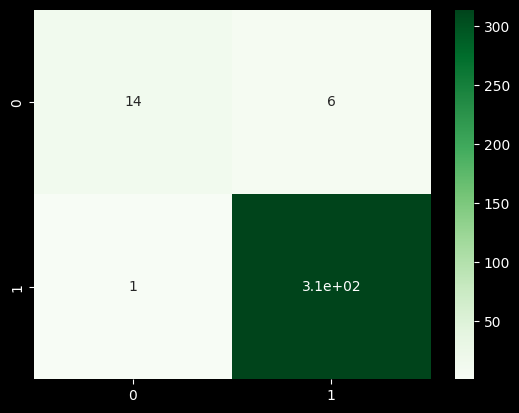

In [214]:
import seaborn as sns 
plt.xlabel("")
sns.heatmap(conf_mtx, annot = True, cmap = "Greens")

In [215]:
TP = conf_mtx[0][0]
FP = conf_mtx[1][0]
TN = conf_mtx[1][1]
FN = conf_mtx[0][1]

print(TP, FP, TN, FN)

14 1 314 6


## Evaluation Metrics

Precision is calculated as follows: $$ \frac{TP}{(TP + FP)} $$

Recall is calculated as follows: $$ \frac{TP}{(TP + FN)} $$

f1Score is calculated as follows: $$ \frac{Precision * Recall}{(Precision + Recall)} $$ 

In [216]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1score = (precision * recall) / (precision + recall)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'f1score: {f1score}')


Precision: 0.9333333333333333
Recall: 0.7
f1score: 0.4
